In [1]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from skimage.feature import hog

# --- Paths ---
BASE = Path(r"c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project")
DATA = BASE / "data"
OUR_DIR = DATA / "our_images"
MODEL_PATH = BASE / "models" / "final_model.pkl"

# --- Image/grid config ---
IMG_W, IMG_H = 800, 600
CELL_W, CELL_H = IMG_W // 8, IMG_H // 8

# --- Feature config ---
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    feature_vector=True
)
HIST_BINS = 16

print("MODEL_PATH exists:", MODEL_PATH.exists())
print("OUR_DIR exists:", OUR_DIR.exists())


MODEL_PATH exists: True
OUR_DIR exists: True


In [2]:
def _to_bgr(img):
    if img is None:
        return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img

def center_crop_to_aspect(img, aspect=4/3):
    h, w = img.shape[:2]
    cur = w / h
    if abs(cur - aspect) < 1e-6:
        return img
    if cur > aspect:
        new_w = int(h * aspect)
        x0 = (w - new_w) // 2
        return img[:, x0:x0 + new_w]
    else:
        new_h = int(w / aspect)
        y0 = (h - new_h) // 2
        return img[y0:y0 + new_h, :]

def preprocess(img):
    """
    1) BGR
    2) center-crop to 4:3
    3) if cropped < 800x600 -> return None (skip)
    4) else downscale to 800x600 (no upscaling)
    """
    bgr = _to_bgr(img)
    if bgr is None:
        return None
    cropped = center_crop_to_aspect(bgr, aspect=4/3)
    h, w = cropped.shape[:2]
    if w < IMG_W or h < IMG_H:
        print(f"⚠️  Skipping (too small after crop): {w}x{h} (< {IMG_W}x{IMG_H})")
        return None
    return cv2.resize(cropped, (IMG_W, IMG_H), interpolation=cv2.INTER_AREA)


In [3]:
def color_hist(cell_bgr, bins=HIST_BINS):
    rgb = cv2.cvtColor(cell_bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(cell_bgr, cv2.COLOR_BGR2HSV)
    feats = []
    for space in (rgb, hsv):
        for ch in range(3):
            h, _ = np.histogram(space[:, :, ch], bins=bins, range=(0, 255), density=True)
            feats.append(h.astype(np.float32))
    return np.concatenate(feats)  # 96 dims when bins=16

def hog_feats(cell_bgr):
    gray = cv2.cvtColor(cell_bgr, cv2.COLOR_BGR2GRAY)
    return hog(gray, **HOG_PARAMS).astype(np.float32)

def extract_features(cell_bgr):
    return np.concatenate([color_hist(cell_bgr), hog_feats(cell_bgr)]).astype(np.float32)

def slice_cells(img):
    cells = []
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            cells.append(img[y0:y1, x0:x1])
    return cells


In [4]:
def slice_cells(img):
    cells = []
    for r in range(8):
        for c in range(8):
            y0,y1 = r*CELL_H,(r+1)*CELL_H
            x0,x1 = c*CELL_W,(c+1)*CELL_W
            cells.append(img[y0:y1, x0:x1])
    return cells

def draw_overlay(img, preds):
    out = img.copy()
    k=0
    for r in range(8):
        for c in range(8):
            y0,y1 = r*CELL_H,(r+1)*CELL_H
            x0,x1 = c*CELL_W,(c+1)*CELL_W
            if preds[k]==1:
                cv2.rectangle(out,(x0,y0),(x1,y1),(0,255,0),2)
            k+=1
    return out


In [5]:
with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

print("Model loaded:", type(model).__name__)


Model loaded: Pipeline



=== photo-1598755257130-c2aaca1f061c.jpg ===


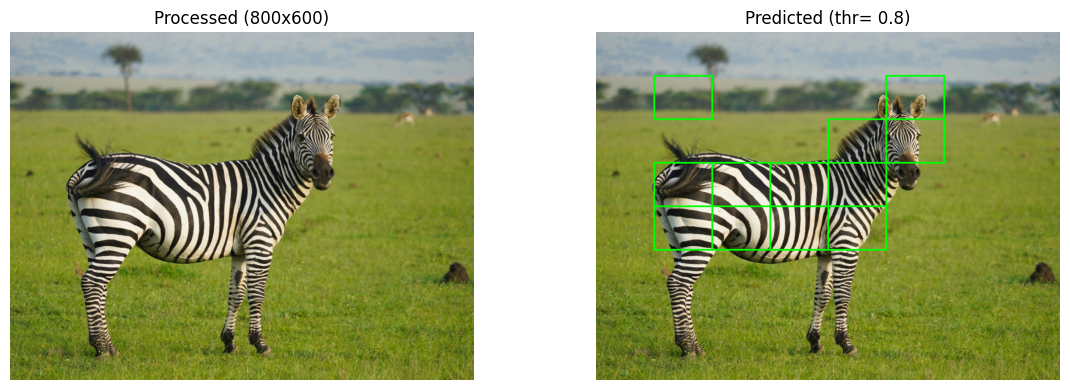


=== WhatsApp Image 2025-11-05 at 00.33.57_0f4624df.jpg ===


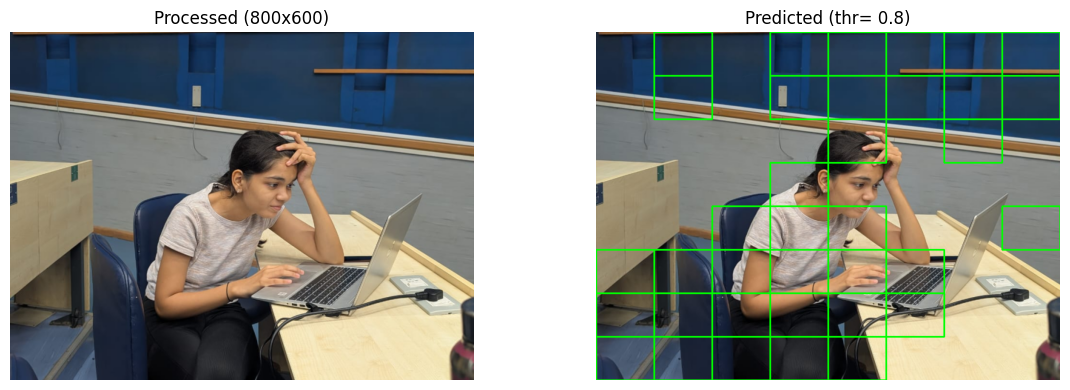


=== WhatsApp Image 2025-11-05 at 00.35.16_d57207ff.jpg ===
⚠️  Skipping (too small after crop): 533x400 (< 800x600)
➡️  skipped (too small after crop)

=== WhatsApp Image 2025-11-05 at 00.35.31_5b1286c0.jpg ===
⚠️  Skipping (too small after crop): 197x148 (< 800x600)
➡️  skipped (too small after crop)

=== WhatsApp Image 2025-11-05 at 00.35.39_c8105513.jpg ===
⚠️  Skipping (too small after crop): 187x140 (< 800x600)
➡️  skipped (too small after crop)


,ImageFileName,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
0,photo-1598755257130-c2aaca1f061c.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WhatsApp Image 2025-11-05 at 00.33.57_0f4624df...,0,1,0,1,1,1,1,1,0,...,0,0,1,1,1,1,1,0,0,0


In [6]:
from matplotlib import pyplot as plt

images = sorted([p for p in OUR_DIR.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])
if not images:
    print(f"No supported images in {OUR_DIR}")

all_rows = []
for img_path in images:
    print(f"\n=== {img_path.name} ===")
    raw = cv2.imread(str(img_path))
    if raw is None:
        print("❌ unreadable, skipping")
        continue

    proc = preprocess(raw)
    if proc is None:
        print("➡️  skipped (too small after crop)")
        continue

    cells = slice_cells(proc)
    X = np.vstack([extract_features(c) for c in cells])

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    else:
        dec = model.decision_function(X)
        proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    thres = 0.8
    preds = (proba >= thres).astype(int)

    # assemble row (no saving)
    row = {"ImageFileName": img_path.name}
    for i, v in enumerate(preds, start=1):
        row[f"c{i:02d}"] = int(v)
    all_rows.append(row)

    # overlay
    overlay = proc.copy()
    k = 0
    for r in range(8):
        for c in range(8):
            y0, y1 = r*CELL_H, (r+1)*CELL_H
            x0, x1 = c*CELL_W, (c+1)*CELL_W
            if preds[k] == 1:
                cv2.rectangle(overlay, (x0, y0), (x1, y1), (0, 255, 0), 2)
            k += 1

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Processed (800x600)")
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Predicted (thr= " + str(thres) + ")")
    plt.tight_layout(); plt.show()

# Final table (not saved)
preds_df = pd.DataFrame(all_rows, columns=["ImageFileName"] + [f"c{i:02d}" for i in range(1,65)])
preds_df
